# King County

In [1]:
%%capture
import sys
!ln -s ../syntheticml .
!{sys.executable} -m pip install -r ../requirements.txt
!{sys.executable} -m pip install -U kaleido
!{sys.executable} -m pip install git+https://github.com/mostly-ai/virtualdatalab.git

In [2]:
import pandas as pd
df = pd.read_csv('../datasets/kingcounty/raw/kc_house_data.csv');
df.sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
20514,4092300211,20141024T000000,384000.0,3,2.25,990,736,2.5,0,0,...,8,880,110,2009,0,98105,47.6605,-122.319,1030,1201
12394,7686203385,20150326T000000,204000.0,3,1.00,980,8000,1.0,0,0,...,6,980,0,1954,0,98198,47.4200,-122.317,1240,8000
3248,798000535,20140625T000000,308000.0,3,1.00,1640,18144,1.5,0,0,...,6,1640,0,1942,0,98168,47.5027,-122.330,1500,9065


In [3]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
syn = Synthetic(df, 
        id="id",
        #category_columns=("condition", "floors", "grade", "view", "waterfront", "yr_built", "yr_renovated", "zipcode", "bathrooms", "bedrooms",),
        category_columns=("condition", "floors", "grade", "view", "waterfront", "zipcode", "bathrooms", "bedrooms",),
        #exclude_columns=('date',),
        synthetic_folder = "../datasets/kingcounty/synth",
        models=MODELS.keys(),
        target_column="price",
        n_sample = 21613,
        max_cpu_pool=1
)

In [4]:
%%capture  --no-display
syn.process()

syn.process_scores()


## Metricas
### Continuas

In [5]:
metrics = syn.current_metrics()
metrics[~metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
0,lat,"[47.5402, 47.6875, 47.686, 47.6624, 47.5518]","[14, 13, 13, 13, 13]","[0.0008097165991902834, 0.0007518796992481203,...",False,17290.0,0.0,47.560330,0.001053,47.562393,...,0.000810,47.5718,47.192729,47.257334,47.3107,47.472,47.678,4.774995e+01,4.777281e+01,4.777670e+01
1,sqft_living,"[1400, 1300, 1720, 1250, 1540]","[109, 107, 106, 106, 105]","[0.006304222093695778, 0.006188548293811452, 0...",False,17290.0,0.0,2073.894910,6.900053,2087.418766,...,0.006304,1910.0000,522.890000,720.000000,940.0000,1430.000,2540.000,3.740000e+03,4.921100e+03,6.965550e+03
2,sqft_lot,"[5000, 4000, 6000, 7200, 4800]","[301, 209, 208, 179, 98]","[0.017408906882591092, 0.012087912087912088, 0...",False,17290.0,0.0,14798.947368,295.374719,15377.871180,...,0.017409,7600.0000,737.156000,1005.000000,1756.0000,5001.250,10606.750,4.299910e+04,2.121922e+05,4.356000e+05
3,sqft_basement,"[0, 600, 700, 500, 800]","[10553, 182, 169, 167, 164]","[0.6103528050896472, 0.010526315789473684, 0.0...",False,17290.0,0.0,287.932736,3.336545,294.472244,...,0.610353,0.0000,0.000000,0.000000,0.0000,0.000,550.000,1.180000e+03,1.650000e+03,2.324220e+03
7,price,"[350000.0, 450000.0, 425000.0, 550000.0, 32500...","[143, 140, 123, 123, 123]","[0.008270676691729323, 0.008097165991902834, 0...",False,17290.0,0.0,537768.047947,2748.953957,543155.898699,...,0.008271,450000.0000,95000.000000,154467.000000,210000.0000,320150.000,640000.000,1.150000e+06,1.950000e+06,3.331995e+06
10,yr_renovated,"[0, 2014, 2005, 2000, 2003]","[16571, 76, 32, 30, 29]","[0.9584152689415847, 0.004395604395604396, 0.0...",False,17290.0,0.0,83.003412,3.030640,88.943358,...,0.958415,0.0000,0.000000,0.000000,0.0000,0.000,0.000,0.000000e+00,2.008000e+03,2.014000e+03
11,long,"[-122.29, -122.362, -122.288, -122.3, -122.372]","[100, 88, 81, 81, 81]","[0.00578368999421631, 0.005089647194910353, 0....",False,17290.0,0.0,-122.214139,0.001068,-122.212045,...,0.005784,-122.2310,-122.497000,-122.408000,-122.3870,-122.329,-122.125,-1.219790e+02,-1.217870e+02,-1.216989e+02
14,sqft_above,"[1300, 1010, 1200, 1220, 1140]","[166, 165, 160, 152, 148]","[0.009600925390399074, 0.009543088490456911, 0...",False,17290.0,0.0,1785.962175,6.248515,1798.209039,...,0.009601,1560.0000,520.000000,700.000000,850.0000,1200.000,2200.000,3.380000e+03,4.371100e+03,6.070000e+03
15,sqft_living15,"[1440, 1540, 1560, 1500, 1610]","[156, 154, 152, 137, 136]","[0.009022556390977444, 0.008906882591093117, 0...",False,17290.0,0.0,1982.904569,5.180812,1993.058774,...,0.009023,1840.0000,740.000000,950.000000,1140.0000,1480.000,2360.000,3.280000e+03,4.050000e+03,4.985550e+03
18,yr_built,"[2014, 2005, 2006, 2004, 2007]","[449, 371, 366, 350, 347]","[0.025968768074031232, 0.02145748987854251, 0....",False,17290.0,0.0,1971.108329,0.223859,1971.547085,...,0.025969,1975.0000,1900.000000,1904.000000,1915.0000,1951.000,1997.000,2.011000e+03,2.014000e+03,2.015000e+03


### Categoricas

In [6]:
metrics[metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
4,view,"[0, 2, 3, 1, 4]","[15586, 783, 396, 275, 250]","[0.901445922498554, 0.045286292654713706, 0.02...",True,17290.0,17290.0
5,condition,"[3, 4, 5, 2, 1]","[11248, 4512, 1364, 139, 27]","[0.6505494505494506, 0.2609600925390399, 0.078...",True,17290.0,17290.0
6,bedrooms,"[3, 4, 2, 5, 6]","[7865, 5477, 2237, 1292, 212]","[0.4548872180451128, 0.3167727009832273, 0.129...",True,17290.0,17290.0
8,date,"[20140623T000000, 20140625T000000, 20140626T00...","[123, 105, 101, 101, 101]","[0.007113938692886061, 0.006072874493927126, 0...",True,17290.0,17290.0
9,grade,"[7, 8, 9, 6, 10]","[7201, 4879, 2072, 1620, 915]","[0.4164835164835165, 0.28218623481781374, 0.11...",True,17290.0,17290.0
12,floors,"[1.0, 2.0, 1.5, 3.0, 2.5]","[8488, 6628, 1523, 517, 128]","[0.4909196067090804, 0.383342972816657, 0.0880...",True,17290.0,17290.0
13,bathrooms,"[2.5, 1.0, 1.75, 2.25, 2.0]","[4333, 3088, 2425, 1621, 1526]","[0.2506072874493927, 0.17860034702139965, 0.14...",True,17290.0,17290.0
16,waterfront,"[0, 1]","[17166, 124]","[0.9928282244071718, 0.007171775592828224]",True,17290.0,17290.0
17,zipcode,"[98103, 98038, 98115, 98052, 98117]","[489, 473, 462, 459, 455]","[0.028282244071717755, 0.027356853672643146, 0...",True,17290.0,17290.0


In [16]:
len(metrics[~metrics.is_categorical].dropna(axis=1, how='all').columns)-1+len(metrics[metrics.is_categorical].dropna(axis=1, how='all').columns)-1

40

## Scores

In [7]:
best_model = "tddpm_mlp_21613"
second_best_model = "smote-enc_21613"
avg = syn.scores[syn.scores["type"] == "avg"]
avg.sort_values("score", ascending=False).loc[["tddpm_mlp_21613","smote-enc_21613","gaussiancopula_noise_21613","tvae_21613", "tvae_noise_21613","gaussiancopula_21613","copulagan_noise_21613","copulagan_21613","ctgan_noise_21613","ctgan_21613"],["score", "DCR ST 5th", "DCR SH 5th", "DCR TH 5th"]]
#["tddpm_mlp_21613","smote-enc_21613","gaussiancopula_noise_21613","tvae_21613", "tvae_noise_21613","gaussiancopula_21613","copulagan_noise_21613","copulagan_21613","ctgan_noise_21613","ctgan_21613"]

,score,DCR ST 5th,DCR SH 5th,DCR TH 5th
name,,,,
tddpm_mlp_21613,0.962789,0.084187,0.104472,0.03575
smote-enc_21613,0.954592,0.058759,0.090209,0.03575
gaussiancopula_noise_21613,0.827655,0.209163,0.229880,0.03575
tvae_21613,0.819230,0.108154,0.133609,0.03575
tvae_noise_21613,0.814853,0.121998,0.139551,0.03575
gaussiancopula_21613,0.812633,0.206765,0.226026,0.03575
copulagan_noise_21613,0.803317,0.230017,0.253036,0.03575
copulagan_21613,0.780299,0.219406,0.242047,0.03575
ctgan_noise_21613,0.760218,0.207462,0.230596,0.03575


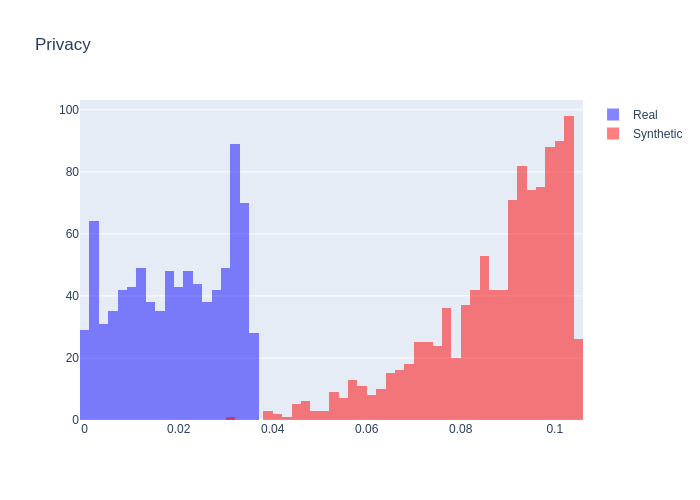

None

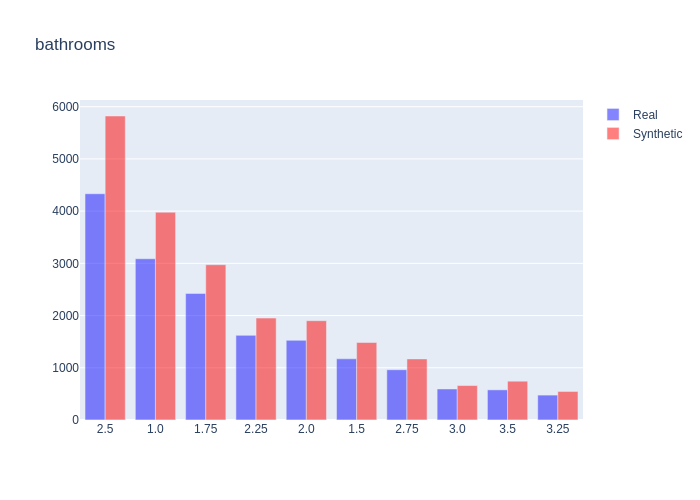

None

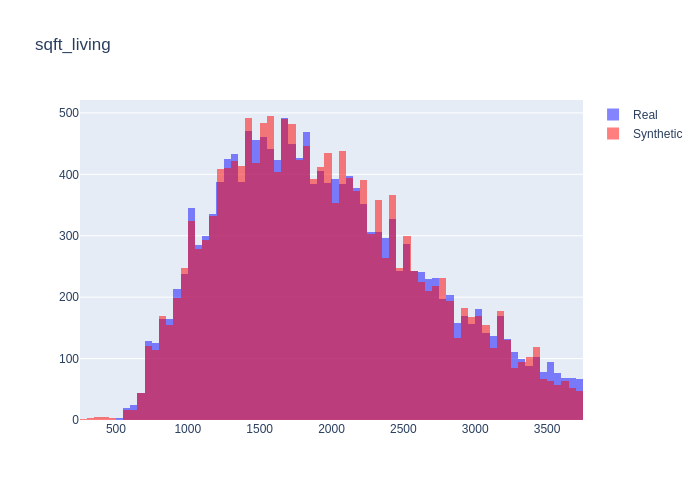

None

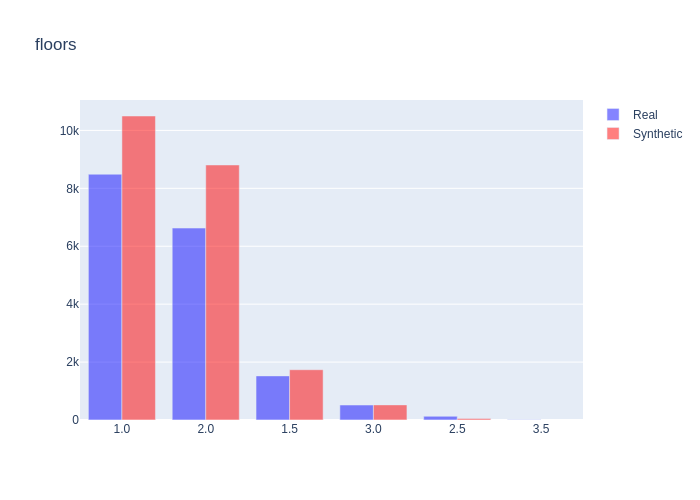

None

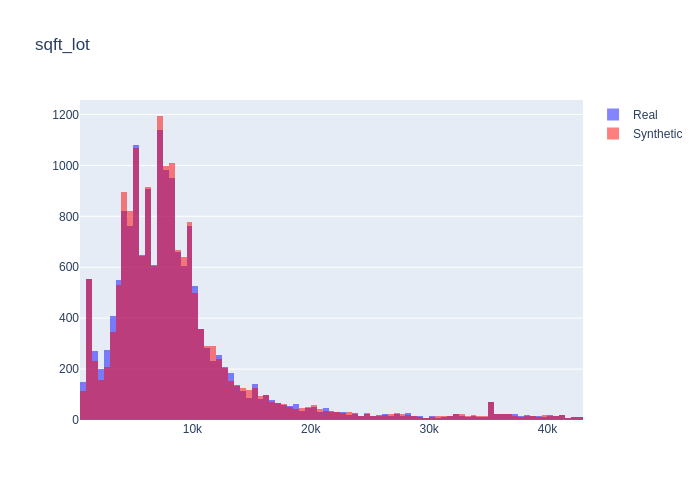

None

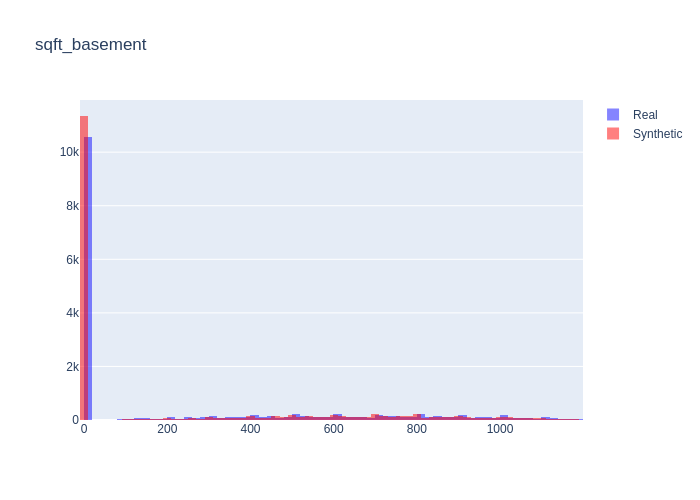

None

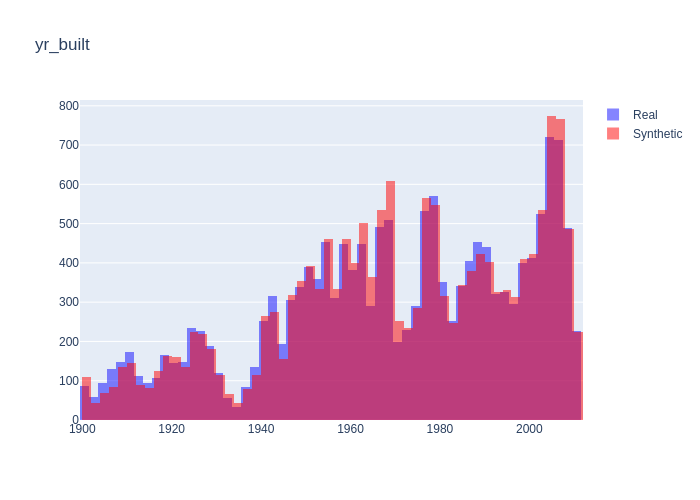

None

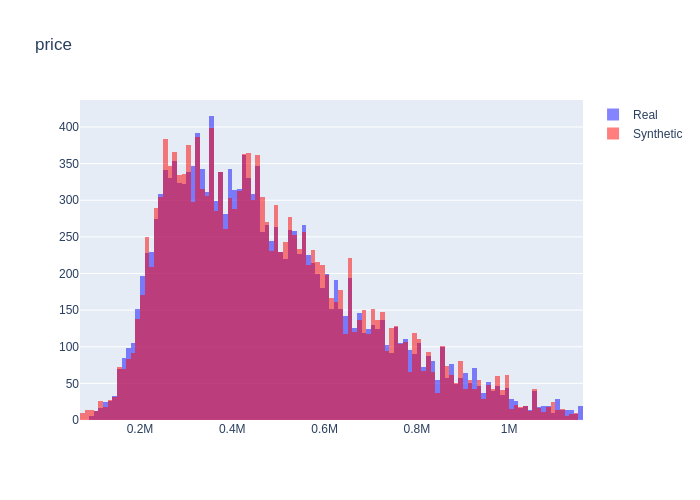

None

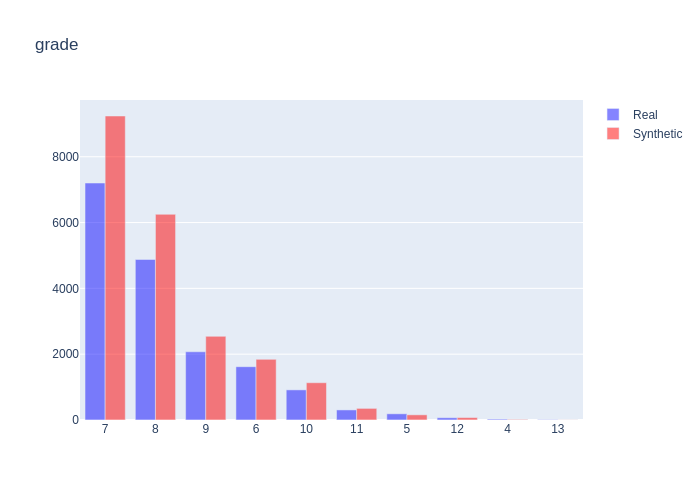

None

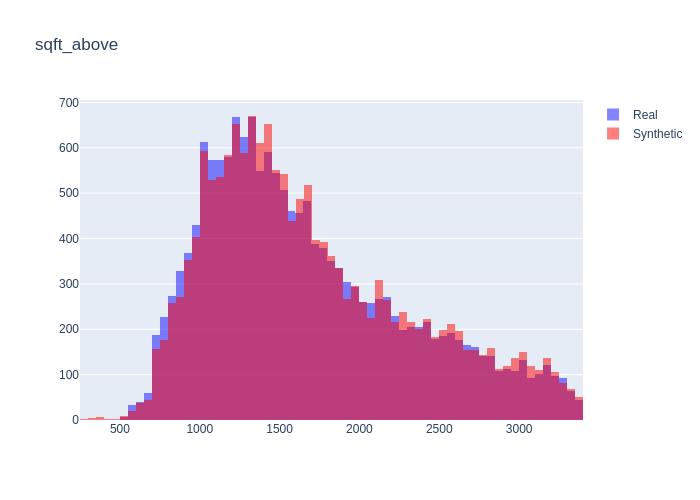

None

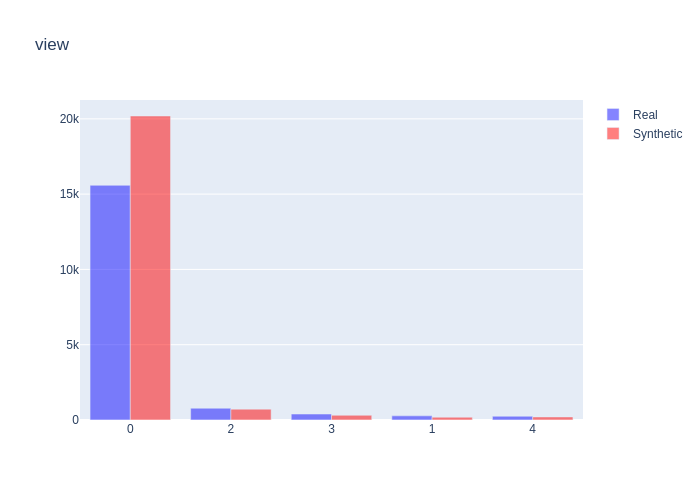

None

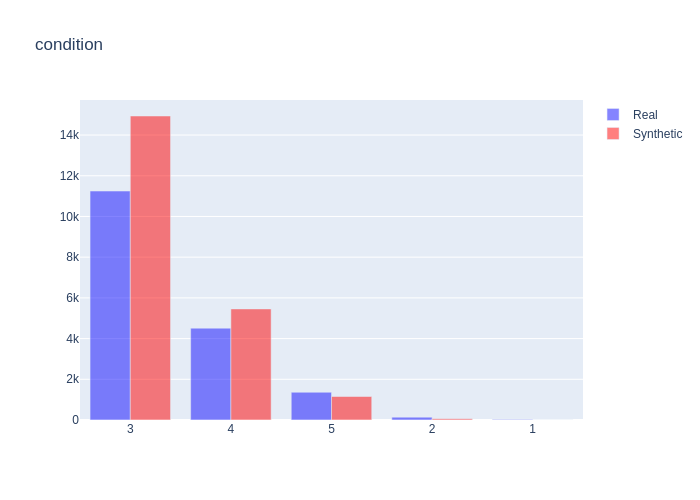

None

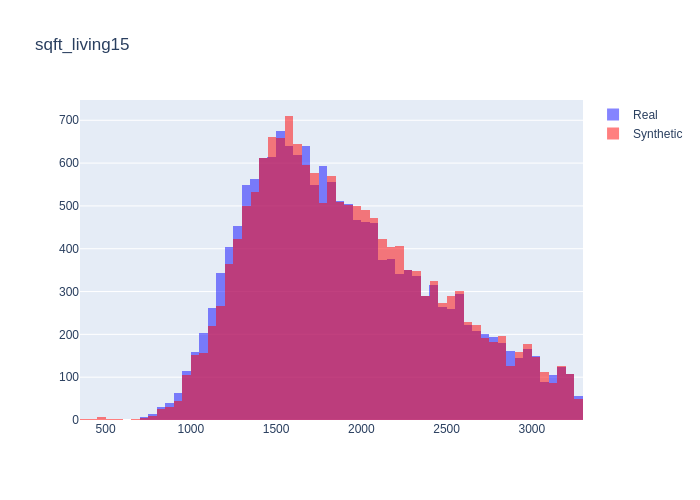

None

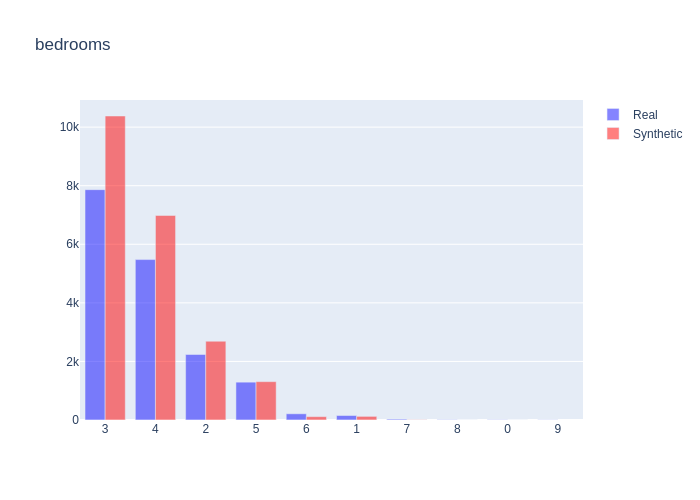

None

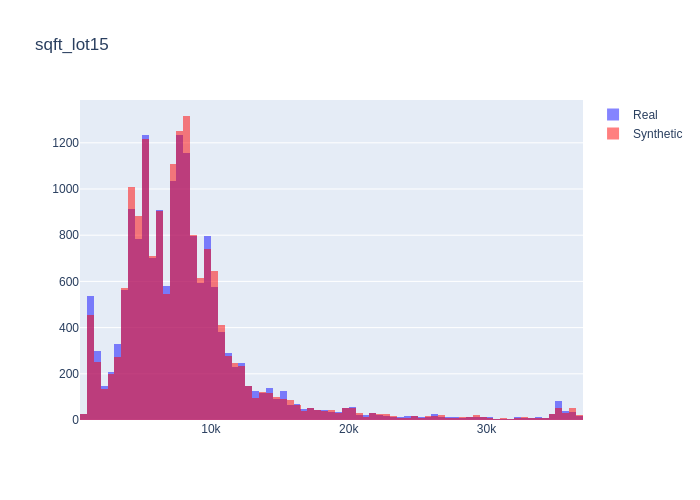

None

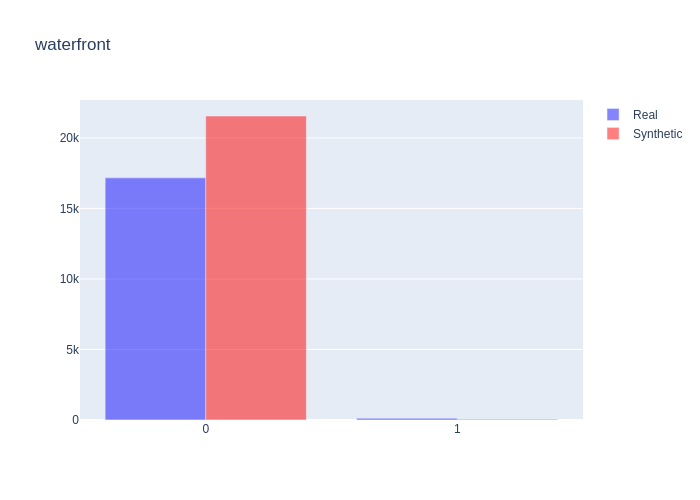

None

In [8]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))

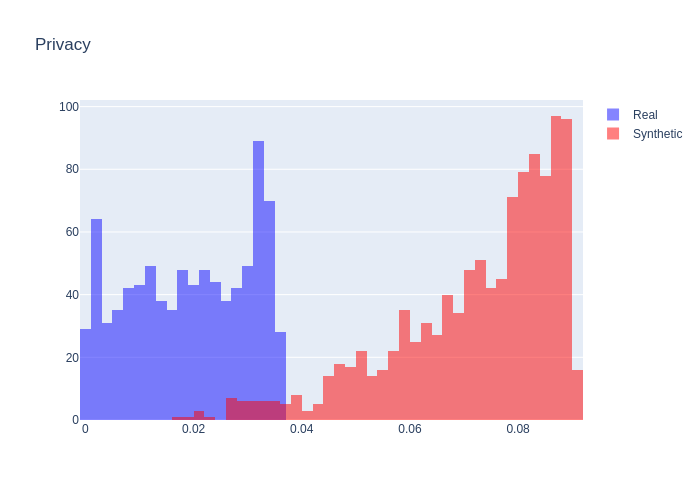

None

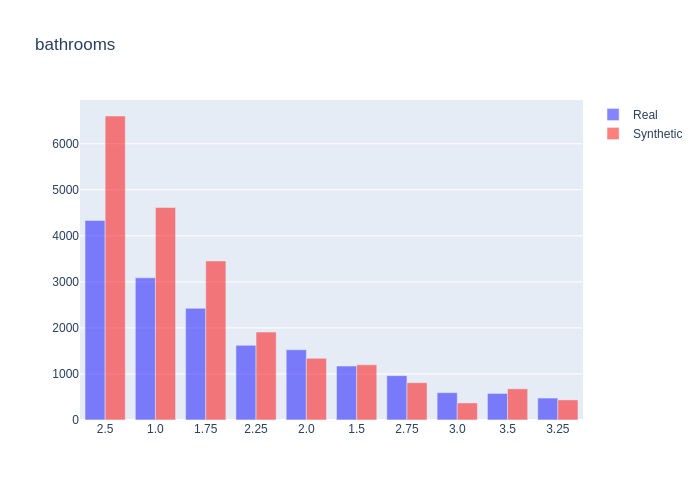

None

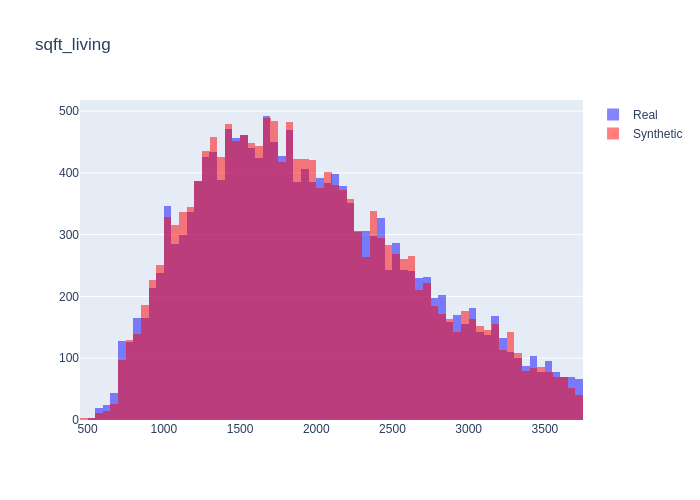

None

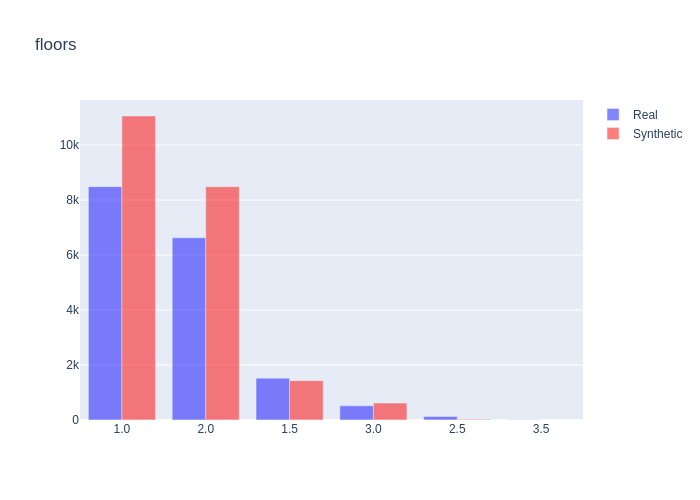

None

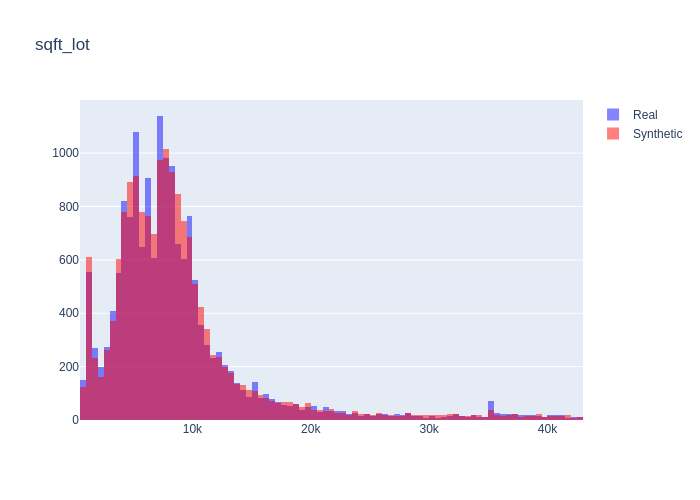

None

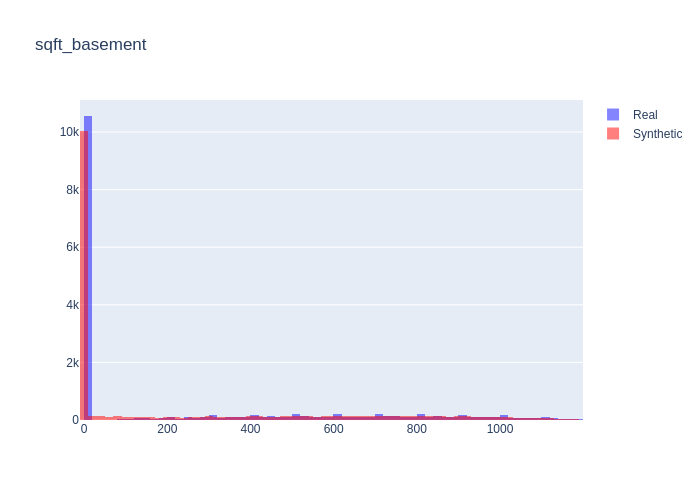

None

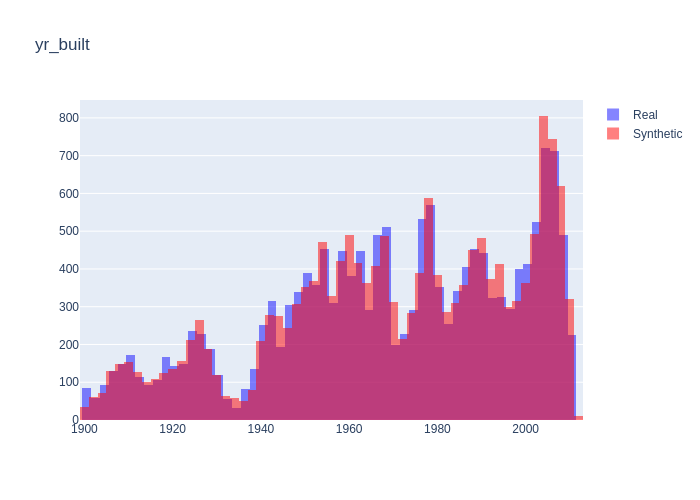

None

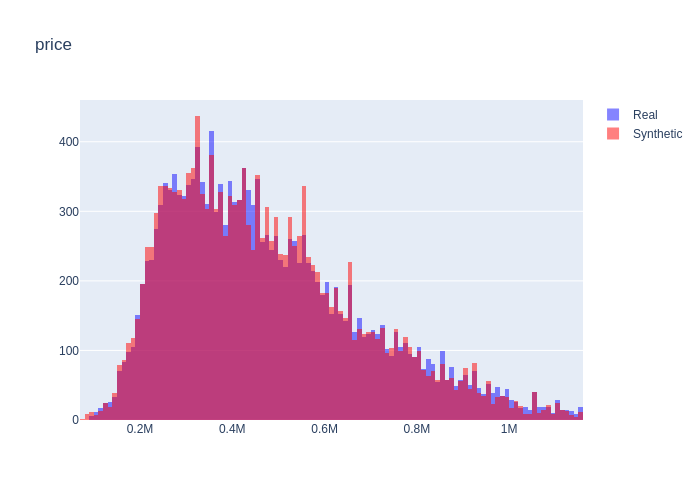

None

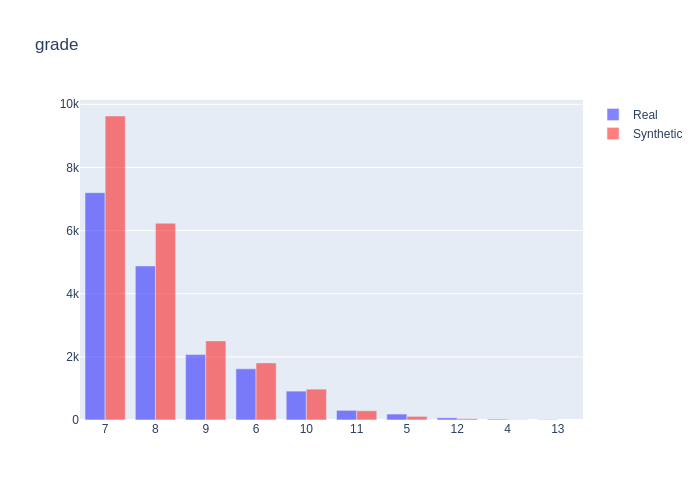

None

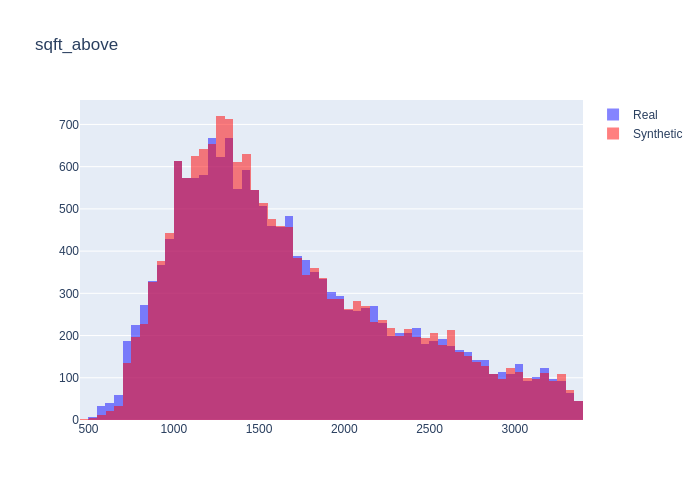

None

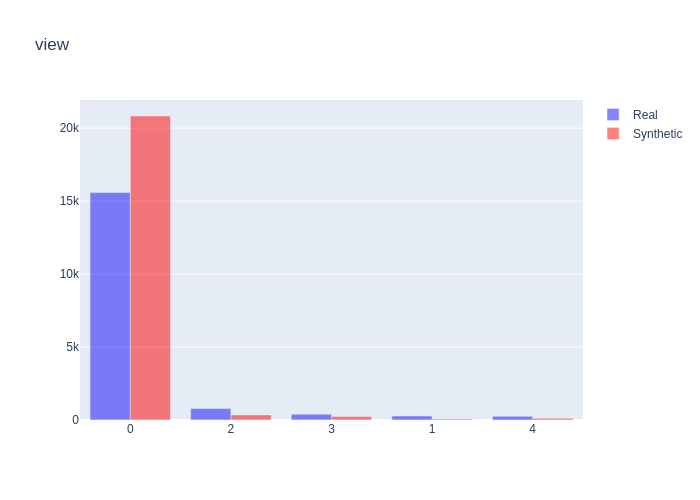

None

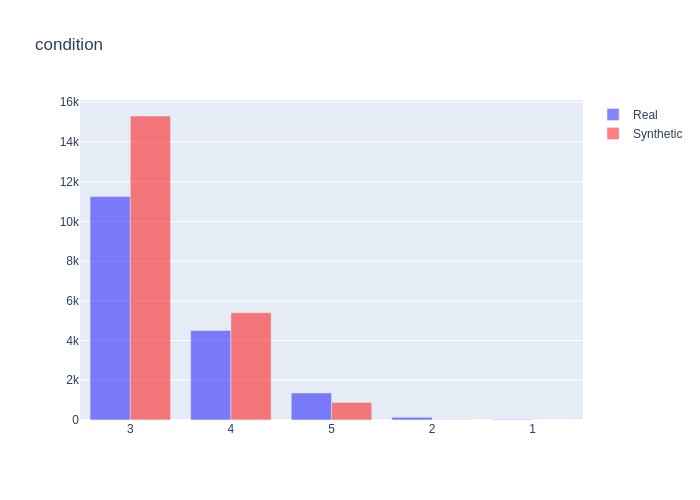

None

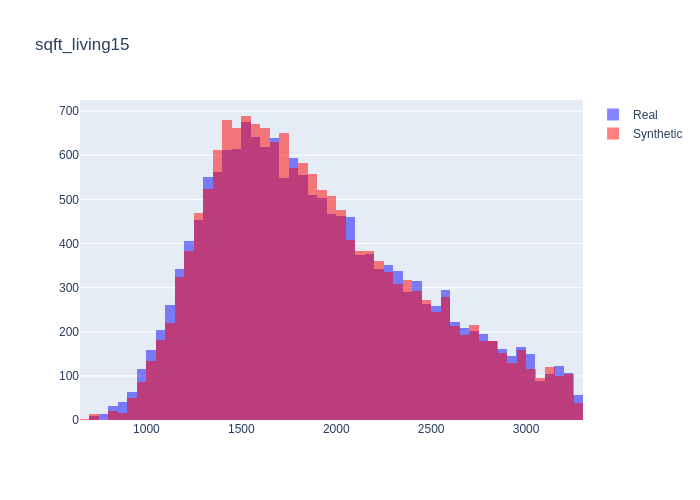

None

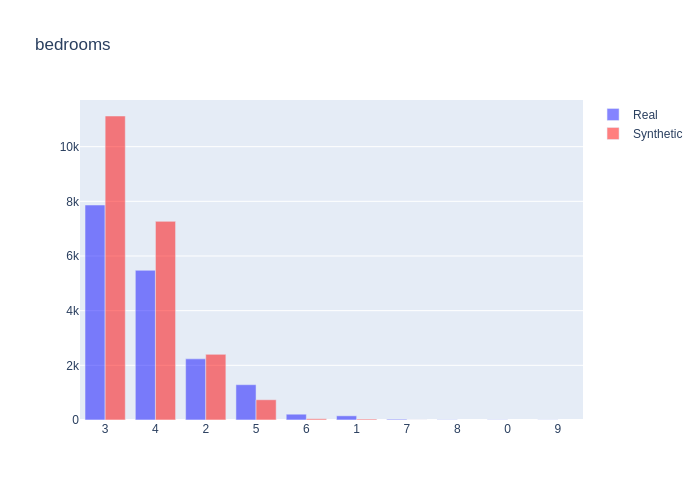

None

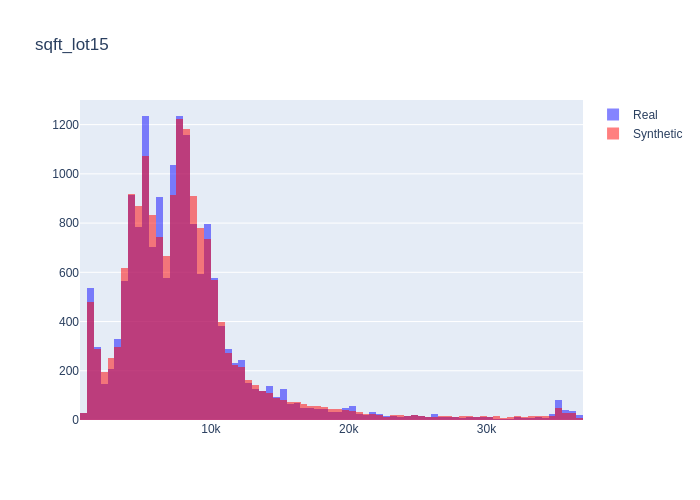

None

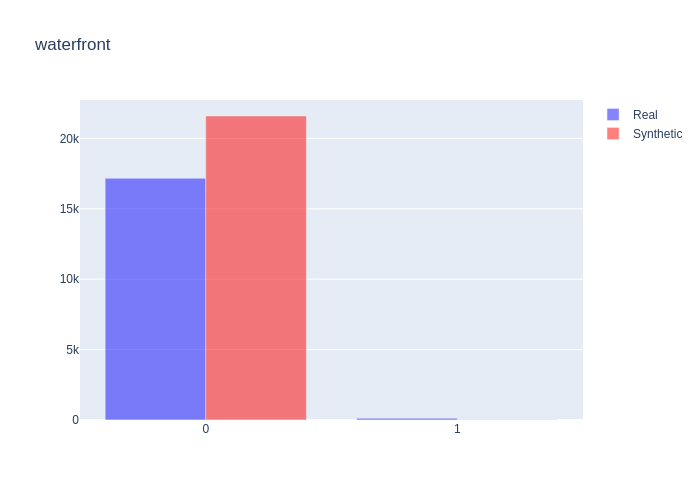

None

In [9]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(second_best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))

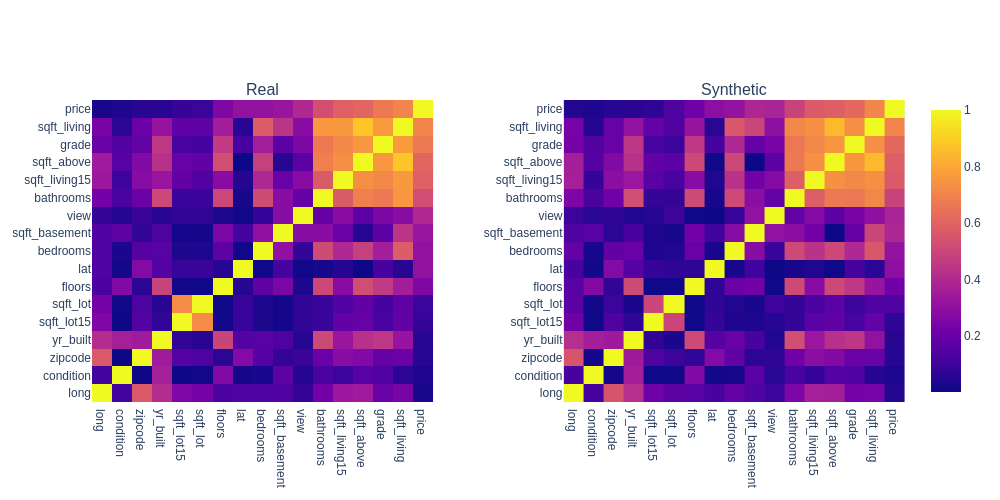

In [10]:
syn.charts.pair_corr(syn.df, syn.fake_data[best_model], {'id', 'waterfront', 'yr_renovated'}, "price").update_layout(dict(width=1000)).show("png")

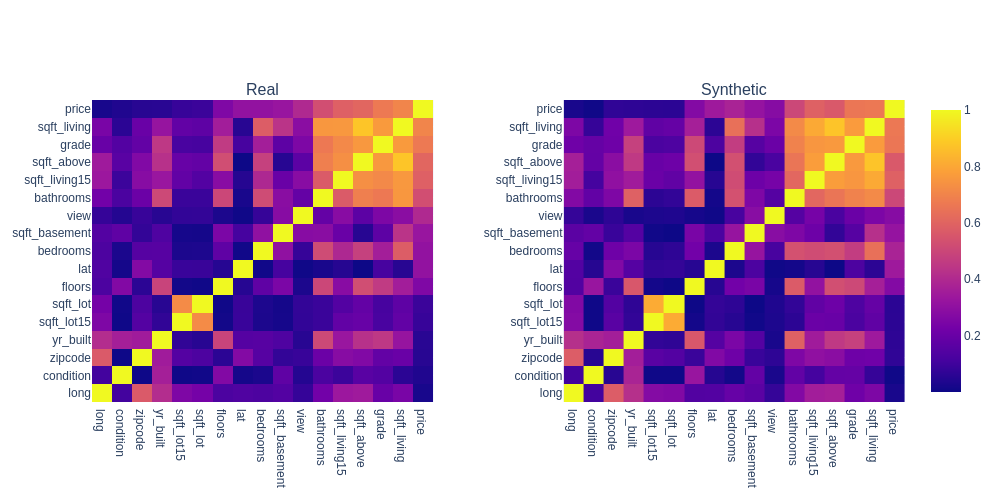

In [11]:
syn.charts.pair_corr(syn.df, syn.fake_data[second_best_model], {'id', 'waterfront', 'yr_renovated'}, "price").update_layout(dict(width=1000)).show("png")

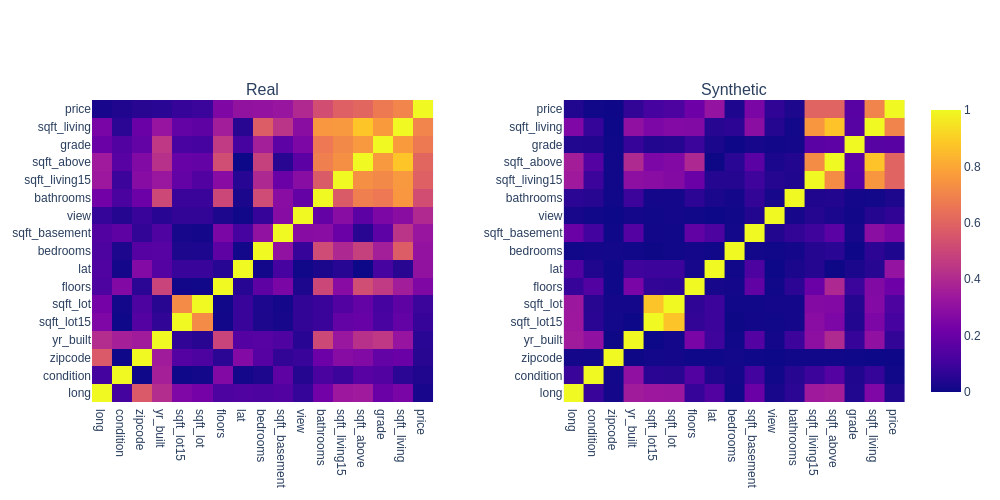

In [12]:
syn.charts.pair_corr(syn.df, syn.fake_data["gaussiancopula_21613"], {'id', 'waterfront', 'yr_renovated'}, "price").update_layout(dict(width=1000)).show("png")